# Pryngles module: Spangler

This module contains all the physics of light scattered on spangles

In [1]:
from pryngles import *

## External modules

In [2]:
import pandas as pd
from collections import OrderedDict as odict
from copy import deepcopy
import random

#Aliases
print_df=Misc.print_df
sci=Science

## The Spangler class

This class contains a family of routines useful for spangling different kind of objects.

In [3]:
Spangler_doc=\
"""A Spangler associated to an object or set of objects.
    
   There are two ways to initialize a Spangler:
    
        Creating a Spangler for a single object:
        
            Mandatory:

                nspangles: int, default = 0:
                    Number of spangles in spangling.

            Optional:

                body_hash: string, default = None:
                    Hash identifying the body to which spangles are associated 
                    (see Body documentation for explanation about hash).

                spangle_type: int, default = 0:
                    Type of spangle (see *_SPANGLE in Consts module).

                n_equ: numpy Array (3), default = [0,0,1]:
                    unitary vector normal to {equ} (equatorial) plane.

                alpha_equ: float, default = 0:
                    Roll angle of x-axis of equatorial system (not implemented yet)

                n_obs: list/array (3), default = []:
                    Normal vector towards the observer.

                alpha_obs: float, default = 0:
                    Roll angle of x-axis of observer system (not implemented yet)

                center_equ: numpy Array (3), default = [0,0,0]:
                    Position of the spnagler in the {equ} (equatorial) system.

                center_ecl: numpy Array (3), default = [0,0,0]:
                    Position of the spnagler in the {ecl} (ecliptic) system.
                    
                w, t0: float [rad, rad/ut, ut], default = 0, 0, 0:
                    Angular velocity and reference time.

        Joining a set of Spanglers (several objects):

            spanglers: list of Spanglers. default = []:
                Set of spanglers to join.
                
            n_obs: numpy Array (3), default = [0,0,1]:
                unitary vector normal to {obs} observer direction.
            
            alpha_obs: float, default = 0:
                Roll angle of x-axis of observer system (not implemented yet)

Core attributes:

    nspangles: int:
        Total number of spangles.

    data: Pandas DataFrame: 
        Dataframe containing all the information about the spangling.
        For Columns see global variable SPANGLER_COLUMNS.

            
Secondary attributes:

    M_ecl2obs, M_obs2ecl: array (3x3):
        Transformation matrices going from {obs} <-> {ecl}.

    M_ecl2equ, M_equ2ecl: array (3x3):
        Transformation matrices going from {equ} <-> {ecl}.
        
    M_ecl2luz, M_luz2ecl: array (3x3):
        Transformation matrices going from {luz} <-> {ecl}.
        
Public methods:
    
    update_positions: update positions by changing observer orientation.
"""

In [23]:
#Columns of spangling
SPANGLER_COLUMNS=odict(
    {
        "body_hash":"",
        
        #Type of spangle
        "type":SOLID_SPANGLE,#For a list of spangle types see the constants module.
        "dim":2,#Dimension of the spangle
        
        #Lengh-scale
        "scale":1,#The length scale of the body, eg. for a ring this is the outer radius
        
        #Coordinates of the spangle (cartesian and spherical) in the ecliptic system
        "center_ecl":[0,0,0],#Center of the body with respect to barycenter
        "x_ecl":0,"y_ecl":0,"z_ecl":0,#Calculated in the class
        "r_ecl":0,"q_ecl":0,"f_ecl":0,#Calculated in the class
        "ns_ecl":[0,0,0],#Unitary vector normal to the spangle, calculated in the class

        #Coordinates of the spangle (cartesian and spherical) in the observer system
        "x_obs":0,"y_obs":0,"z_obs":0,#Calculated in the class
        "r_obs":0,"q_obs":0,"f_obs":0,#Calculated in the class
        "ns_obs":[0,0,0],#Unitary vector normal to the spangle, calculated in the class
        
        #Coordinates of the spangle (cartesian and spherical) in the light-source system
        "x_luz":0,"y_luz":0,"z_luz":0,#Calculated in the class
        "r_luz":0,"q_luz":0,"f_luz":0,#Calculated in the class
        "ns_luz":[0,0,0],#Unitary vector normal to the spangle, calculated in the class

        #Coordinates of the spangle (cartesian and spherical) in the body-centric system
        "n_equ":[0,0,1],#Direction of the equator
        "alpha_equ":0,#Zero meridian of equatorial system
        "center_equ":[0,0,0],#Center of the body with respect to barycenter
        "x_equ":0,"y_equ":0,"z_equ":1,
        "r_equ":0,"q_equ":0,"f_equ":90*Consts.deg,
        "ns_equ":[0,0,1],#Unitary vector normal to the spangle
        
        #Rotational parameteres, q = q0 + w (t - t0)
        "w":0,#Rotational angular velocity
        "t0":0,#Initial time
        
        #Geometrical parameters
        "asp":1.0, #Area of the spangle
        "dsp":1.0, #Effective diameter of spangle, dsp = 2*(asp/pi)**0.5
        
        #Optical parameters
        "albedo_gray_normal":1,
        "tau_gray_optical":0.0,
        
        #Spangle state
        "unset":1, #State has not been set
        "visible":0, #The spangle is visible from observer
        "shadow":0, #The spangle is in the shadow of other spangle
        "illuminated":0, #The spangle is illuminated by the light-source
        "transit":0, #The spangle is transiting
        "indirect":0, #The spangle is indirectly illuminated
        "occult":0, #The spangle is occulted by a light source
        "emit":0, #The spangle is emmitting
        "hidden":0, #The spangle is not taken into account for photometry
        "source":0, #The spangle belongs to a light-source (it does not reflect light)
    }
)

In [5]:
class Spangler(PrynglesCommon):
    
    def __init__(self,
                 #Initialization using specific options
                 nspangles=1,
                 body_hash=None,
                 spangle_type=SOLID_SPANGLE,
                 n_equ=SPANGLER_COLUMNS["n_equ"],
                 alpha_equ=SPANGLER_COLUMNS["alpha_equ"],
                 n_obs=[0,0,1],
                 alpha_obs=0,
                 n_luz=[0,0,1],
                 center_equ=SPANGLER_COLUMNS["center_equ"],
                 center_ecl=SPANGLER_COLUMNS["center_ecl"],
                 w_equ=SPANGLER_COLUMNS["w"],
                 t0_equ=SPANGLER_COLUMNS["t0"],
                 #Initialization with a list of 
                 spanglers=[]):

        #Create a spanglers with a list of other spanglers
        if len(spanglers)>0:
            verbose(VERB_SIMPLE,f"Joining {len(spanglers)} spanglers")
            self._join_spanglers(spanglers,
                                 n_obs=n_obs,alpha_obs=alpha_obs,
                                 n_luz=n_luz)
            
        #Create a spangler with the desired options
        else:
            #Attributes
            self.nspangles=nspangles
            self.geometry="Vanilla"
            
            #Update default values
            self._defaults=deepcopy(SPANGLER_COLUMNS)

            if not body_hash:
                verbose(VERB_SIMPLE,f"Generating random hash")
                self.body_hash=str(random.getrandbits(16))
            else:
                self.body_hash=body_hash
                
            self._defaults.update(dict(body_hash=self.body_hash))
            
            if spangle_type:
                self._defaults.update(dict(type=spangle_type))

            #Create Spangler dataframe
            if self.nspangles>0:
                
                #Create a simple DataFrame with the default values
                self.data=pd.DataFrame([list(self._defaults.values())]*self.nspangles,columns=self._defaults.keys())

                #Update positions
                self.set_positions(n_equ=n_equ,alpha_equ=alpha_equ,
                                   n_obs=n_obs,alpha_obs=alpha_obs,
                                   n_luz=n_luz,
                                   center_equ=center_equ,center_ecl=center_ecl)
        
            else:        
                verbose(VERB_SIMPLE,f"Creating a blank Spangler")
                #Creat a blank DataFrame
                self.data=pd.DataFrame(columns=self._defaults.keys())
                
    # Prototype
    def _join_spanglers(self,spanglers,nobs=[0,0,1],alpha_obs=0,n_luz=[0,0,1]):pass
    
Spangler.__doc__=Spangler_doc

In [6]:
def update_visibility(self):
    """
    Set visibility of spangles
    """
    verbose(VERB_SIMPLE,f"Updating visibility")
    
    #Set state
    self.data.unset=0
    
    #Reset
    self.data.visible=0
    
    #Conditions:
    """
    | Dimension = 2 (ring)
    & Dimension = 3 (sphere) 
    & z_obs > 0: it is towards the observer
    """
    cond=((self.data.dim==3)&([(np.dot(n_ecl,self.n_obs)>0) for n_ecl in self.data.ns_ecl]))|(self.data.dim==2)
    self.data.loc[cond,"visible"]=1

Spangler.update_visibility=update_visibility

In [7]:
def set_observer(self,n_obs=[],alpha_obs=0):
    """
    Set the positions and orientation of spanglers in the observer system.

    Parameters:

        n_obs: list/array (3), default = []:
            Normal vector towards the observer.

    Optional:

        alpha_obs: float, default = 0:
            Roll angle of x-axis of observer system (not implemented yet)

    Return:
        None

    Update:

        Coordinates of the spangles, (x_obs,y_obs,z_obs) and their spherical 
        counterparts (r_obs,t_obs,f_obs).

        Normal to spangles, ns_obs.

        Rotation matrices M_ecl2obs, M_obs2ecl, 
    """
    verbose(VERB_SIMPLE,f"Setting observer")

    if len(n_obs)>0:
        verbose(VERB_VERIFY,f"Generating observer matrices from n_obs = {n_obs}")
        
        #Unitary observer vector
        self.n_obs,one=spy.unorm(n_obs)
        self.alpha_obs=alpha_obs
        self.d_obs=sci.spherical(self.n_obs)

        #Transformation matrices
        self.M_obs2ecl,self.M_ecl2obs=Science.rotation_matrix(self.n_obs,self.alpha_obs)
        
    #Update positions
    self.data[["x_obs","y_obs","z_obs"]]=\
        [np.matmul(self.M_ecl2obs,r) for r in np.array(self.data[["x_ecl","y_ecl","z_ecl"]])]
    self.data[["r_obs","q_obs","f_obs"]]=\
        [sci.spherical(r) for r in np.array(self.data[["x_obs","y_obs","z_obs"]])]
    
    #Update spangles orientations
    self.data["ns_obs"]=[np.matmul(self.M_ecl2obs,n) for n in self.data["ns_ecl"]]
    
    #Update visibility
    self.update_visibility()
    
Spangler.set_observer=set_observer

In [8]:
def update_illumination(self):
    """
    Set illumination of spangles
    """
    verbose(VERB_SIMPLE,f"Updating illumination")

    #Set state
    self.data.unset=0
    
    #Reset
    self.data.illuminated=0
    
    #Conditions:
    """
    | Dimension = 2 (ring)
    & Dimension = 3 (sphere) 
    & z_obs > 0: it is towards the observer
    """
    cond=(self.data.dim==3)&([(np.dot(n_ecl,self.n_luz)>0) for n_ecl in self.data.ns_ecl])
    self.data.loc[cond,"illuminated"]=1
    
Spangler.update_illumination=update_illumination

In [9]:
def set_luz(self,n_luz=[]):
    """
    Set the positions and orientation of spanglers in the light-source {luz} system.

    Parameters:

        n_luz: list/array (3), default = []:
            Normal vector towards the light-source.

    Return:
        None

    Update:

        Coordinates of the spangles, (x_luz,y_luz,z_luz) and their spherical 
        counterparts (r_luz,t_luz,f_luz).

        Normal to spangles, ns_luz.

        Rotation matrices M_ecl2luz, M_luz2ecl, 
    """
    verbose(VERB_SIMPLE,f"Setting light-source")

    if len(n_luz)>0:
        verbose(VERB_VERIFY,f"Generating light-source matrices from n_luz = {n_luz}")
        
        #Unitary luzerver vector
        self.n_luz,one=spy.unorm(n_luz)
        self.d_luz=sci.spherical(self.n_luz)

        #Transformation matrices
        self.M_luz2ecl,self.M_ecl2luz=Science.rotation_matrix(self.n_luz,0)
        
    #Update positions
    self.data[["x_luz","y_luz","z_luz"]]=\
        [np.matmul(self.M_ecl2luz,r) for r in np.array(self.data[["x_ecl","y_ecl","z_ecl"]])]
    self.data[["r_luz","q_luz","f_luz"]]=\
        [sci.spherical(r) for r in np.array(self.data[["x_luz","y_luz","z_luz"]])]
    
    #Update spangles orientations
    self.data["ns_luz"]=[np.matmul(self.M_ecl2luz,n) for n in self.data.ns_ecl]
    
    #Update illumination
    self.update_illumination()

Spangler.set_luz=set_luz

In [10]:
def set_rotation(self,body_hash,w,t0):
    """
    Set rotational parameters
    """
    cond=(self.data.body_hash==body_hash)
    self.data.loc[cond,"w"]=w
    self.data.loc[cond,"t0"]=t0
    
Spangler.set_rotation=set_rotation

In [11]:
def set_positions(self,
                  n_equ=[],alpha_equ=0,
                  n_obs=[],alpha_obs=0,
                  n_luz=[],
                  center_equ=[],center_ecl=[],
                  t=None
                 ):
    """
    Set the positions and orientation of spanglers in all reference systems.

    Parameters:

        n_equ: list/array (3), default = []:
            Normal vector towards north pole equatorial system.

        n_obs: list/array (3), default = []:
            Normal vector towards the observer.
            
        n_obs: list/array (3), default = []:
            Normal vector towards the light-source.
            
        center_equ: list/array (3), default = []:
            Location of the center of the body with respect to the barycenter.
            
        center_ecl: list/array (3), default = []:
            Location of the center of the body with respect to the barycenter.
            
        t: float, default = None:
            Time.  This quantity is used to update the equatorial coordinates.

    Optional:

        alpha_equ: float, default = 0:
            Roll angle of x-axis of equatorial system (not implemented yet)

        alpha_obs: float, default = 0:
            Roll angle of x-axis of observer system (not implemented yet)

    Return:
        None

    Update:

        Coordinates of the spangles, (X_ecl,Y_ecl,Z_ecl) and their spherical 
        counterparts (R_ecl,T_ecl,F_ecl) with respect to the barycenter.

        Coordinates of the spangles, (x_ecl,y_ecl,z_ecl) and their spherical 
        counterparts (r_ecl,t_ecl,f_ecl) with respect to the body center.

        Coordinates of the spangles, (x_obs,y_obs,z_obs) and their spherical 
        counterparts (r_obs,t_obs,f_obs).

        Normal to spangles, ns_equ, ns_ecl, ns_obs.

        Rotation matrices M_equ2ecl
    """
    verbose(VERB_SIMPLE,f"Setting positions")

    if len(n_equ)>0:
        verbose(VERB_VERIFY,f"Generating equatorial transformation matrices from n_equ = {n_equ}")
        
        #Unitary equatorial vector
        n_equ,one=spy.unorm(n_equ)
        self.data["n_equ"]=[n_equ]*self.nspangles

        #Transformation matrices
        self.M_equ2ecl,self.M_ecl2equ=sci.rotation_matrix(n_equ,alpha_equ)
        
    if len(n_obs)>0:
        self.n_obs,one=spy.unorm(n_obs)

    if len(n_luz)>0:
        self.n_luz,one=spy.unorm(n_luz)
     
    #Update equatorial coordinates by rotation
    if t is not None:
        verbose(VERB_VERIFY,f"Updating rotations at t = {t}")

        self.data["q_equ"]=[q+w*(t-t0) for q,w,t0 in zip(self.data.q_equ,self.data.w,self.data.t0)]
        self.data[["x_equ","y_equ","z_equ"]]=\
            [sci.cartesian(r) for r in np.array(self.data[["r_equ","q_equ","f_equ"]])]
        #Update normal vectors
        if self.sample.dim>2:
            self.data["ns_equ"]=[spy.unorm(list(r))[0] for r in np.array(self.data[["x_equ","y_equ","z_equ"]])]
                
    #Update center
    if len(center_equ)>0:
        verbose(VERB_VERIFY,f"Updating center in {{equ}} to {center_equ}")
        self.data["center_equ"]=[center_equ]*self.nspangles
    if len(center_ecl)>0:
        verbose(VERB_VERIFY,f"Updating center {{ecl}} to {center_ecl}")
        self.data["center_ecl"]=[center_ecl]*self.nspangles
        
    #Convert from equatorial to ecliptic
    self.data[["x_ecl","y_ecl","z_ecl"]]=\
        [np.matmul(self.M_equ2ecl,r+cequ)+cecl\
         for r,cequ,cecl in zip(np.array(self.data[["x_equ","y_equ","z_equ"]]),
                      self.data.center_equ,
                      self.data.center_ecl)]
    
    self.data[["r_ecl","q_ecl","f_ecl"]]=\
        [sci.spherical(r) for r in np.array(self.data[["x_ecl","y_ecl","z_ecl"]])]

    #Update spangles orientations
    self.data["ns_ecl"]=[np.matmul(self.M_equ2ecl,n) for n in self.data.ns_equ]
    
    #Update velocities
    #Not implemented yet
    
    #Set observer
    self.set_observer(n_obs=self.n_obs,alpha_obs=alpha_obs)
    
    #Set luz
    self.set_luz(n_luz=self.n_luz)
    
Spangler.set_positions=set_positions

In [12]:
if IN_JUPYTER:
    def test_init(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        print("Basic definition:")
        sg=Spangler(nspangles=3,spangle_type=GRANULAR_SPANGLE)
        Misc.print_df(sg.data.head(5))
        print("Equ->Ecl:\n",sg.M_equ2ecl)
        print("Equ->Obs:\n",sg.M_obs2ecl)

        print("\nAnother definition:")
        sg=Spangler(nspangles=3,n_equ=[1,0,0])
        Misc.print_df(sg.data.head(5))
        print("Equ->Ecl:\n",sg.M_equ2ecl)
        print("Obs->Ecl:\n",sg.M_obs2ecl)

        print("\nDefinition observer:")
        sg=Spangler(nspangles=3,body_hash="123",n_equ=[0,1,0],n_obs=[1,0,0])
        Misc.print_df(sg.data.head(5))
        print("Equ->Ecl:\n",sg.M_equ2ecl)
        print("Obs->Ecl:\n",sg.M_obs2ecl)
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_init=test_init
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

Basic definition:
  VERB1::__init__:: Generating random hash
  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from n_luz = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_illumination:: Updating illumination


,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,r_ecl,q_ecl,f_ecl,ns_ecl,x_obs,y_obs,z_obs,r_obs,q_obs,f_obs,ns_obs,x_luz,y_luz,z_luz,r_luz,q_luz,f_luz,ns_luz,n_equ,alpha_equ,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit,hidden
0,26634,1,2,1,"[0, 0, 0]",0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,1.0,1.0,1,0.0,0,1,0,0,0,0,0,0,0
1,26634,1,2,1,"[0, 0, 0]",0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,1.0,1.0,1,0.0,0,1,0,0,0,0,0,0,0
2,26634,1,2,1,"[0, 0, 0]",0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,1.0,1.0,1,0.0,0,1,0,0,0,0,0,0,0


Equ->Ecl:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Equ->Obs:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Another definition:
  VERB1::__init__:: Generating random hash
  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 0, 0]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from n_luz = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_illumination:: Updating illumi

,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,r_ecl,q_ecl,f_ecl,ns_ecl,x_obs,y_obs,z_obs,r_obs,q_obs,f_obs,ns_obs,x_luz,y_luz,z_luz,r_luz,q_luz,f_luz,ns_luz,n_equ,alpha_equ,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit,hidden
0,19102,0,2,1,"[0, 0, 0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",0,"[0, 0, 0]",0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,1.0,1.0,1,0.0,0,1,0,0,0,0,0,0,0
1,19102,0,2,1,"[0, 0, 0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",0,"[0, 0, 0]",0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,1.0,1.0,1,0.0,0,1,0,0,0,0,0,0,0
2,19102,0,2,1,"[0, 0, 0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]","[1.0, 0.0, 0.0]",0,"[0, 0, 0]",0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,1.0,1.0,1,0.0,0,1,0,0,0,0,0,0,0


Equ->Ecl:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]
Obs->Ecl:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

Definition observer:
  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 1, 0]
      VERB3::rotation_matrix:: Rotation axis: [-1.  0.  0.] [ 0. -0.  1.] [0. 1. 0.]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [1. 0. 0.]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from n_luz = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_illumination:: Updating illumination


,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,r_ecl,q_ecl,f_ecl,ns_ecl,x_obs,y_obs,z_obs,r_obs,q_obs,f_obs,ns_obs,x_luz,y_luz,z_luz,r_luz,q_luz,f_luz,ns_luz,n_equ,alpha_equ,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit,hidden
0,123,0,2,1,"[0, 0, 0]",0.0,1.0,0.0,1.0,1.570796,0.0,"[0.0, 1.0, 0.0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]",0.0,1.0,0.0,1.0,1.570796,0.0,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",0,"[0, 0, 0]",0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,1.0,1.0,1,0.0,0,1,0,0,0,0,0,0,0
1,123,0,2,1,"[0, 0, 0]",0.0,1.0,0.0,1.0,1.570796,0.0,"[0.0, 1.0, 0.0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]",0.0,1.0,0.0,1.0,1.570796,0.0,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",0,"[0, 0, 0]",0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,1.0,1.0,1,0.0,0,1,0,0,0,0,0,0,0
2,123,0,2,1,"[0, 0, 0]",0.0,1.0,0.0,1.0,1.570796,0.0,"[0.0, 1.0, 0.0]",1.0,0.0,0.0,1.0,0.0,0.0,"[1.0, 0.0, 0.0]",0.0,1.0,0.0,1.0,1.570796,0.0,"[0.0, 1.0, 0.0]","[0.0, 1.0, 0.0]",0,"[0, 0, 0]",0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,1.0,1.0,1,0.0,0,1,0,0,0,0,0,0,0


.

Equ->Ecl:
 [[-1.  0.  0.]
 [ 0. -0.  1.]
 [ 0.  1.  0.]]
Obs->Ecl:
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]



----------------------------------------------------------------------
Ran 1 test in 0.543s

OK


In [13]:
def populate_spangler(self,
                      scale=1,seed=0,geometry="circle",preset=False,
                      **geometry_args):
    """Populate data of a Spangler using points generated with a given geometry.
    
    Parameters:
    
        scale: float. default = 1:
            Scale size of the object.
            
        seed: integer. default = 0:
            Value of the integer seed of random number generation (if 0 no random seed is set).
            If a non-zero seed is used the position of the spangle will be always the same.
            
        geometry: string, default = "circle":
            Geometry of the Sampler.  Available: "circle", "ring", "sphere"
            
        preset: boolean, default = False:
            If true the spangler is populated with preset data.
            
        geometry_args: dictionary:
            See Sampler methods documentation.
            
        
    """
    self.geometry=geometry
    
    #Check if preset
    if preset:
        verbose(VERB_SIMPLE,f"Populating spangler from preset for {geometry}")
        preset=(geometry,geometry_args)
        self.sample=Sampler(preset=preset,N=self.nspangles,seed=seed)   
    else:
        self.sample=Sampler(N=self.nspangles,seed=seed)
        exec(f"self.sample.gen_{geometry}(**geometry_args)")
        
    self.data["dim"]=self.sample.dim

    #Purge sample if it is in 3d
    if self.sample.dim>2:
        verbose(VERB_SIMPLE,f"Purging 3d sample")
        self.sample.purge_sample()
                
    #Check if number of samples is not equal to that of spangles
    if self.sample.N!=self.nspangles:
        verbose(VERB_SYSTEM,f"Sample size {self.sample.N} is different from spangles {self.nspangles}. Adjusting.")
        dif=self.sample.N-self.nspangles
        if dif>0:
            verbose(VERB_SYSTEM,f"Adding {dif} entries to DataFrame")
            for i in range(dif):
                df=pd.DataFrame([self.data.iloc[-1]])
                self.data=pd.concat([self.data,df],ignore_index=True)
        else:
            verbose(VERB_SYSTEM,f"Removing {-dif} entries to DataFrame")
            self.data.drop(range(self.nspangles+dif,self.nspangles),inplace=True)
        self.nspangles=self.sample.N
    
    #Area
    self.data["asp"]=self.sample.aes*scale**2
    self.data["dsp"]=2*(self.data["asp"]/np.pi)**0.5
    
    #Update scale
    self.data["scale"]=scale

    #Store positions in DataFrame
    self.data[["x_equ","y_equ","z_equ"]]=self.sample.ss*scale
    self.data[["r_equ","q_equ","f_equ"]]=self.sample.pp
    self.data["r_equ"]*=scale

    #Update normal vectors
    if self.sample.dim>2:
        self.data["ns_equ"]=[spy.unorm(list(r))[0] for r in np.array(self.data[["x_equ","y_equ","z_equ"]])]
    else:
        self.data["ns_equ"]=[[0,0,1]]*self.nspangles
        
    #Update positions
    self.set_positions()
    
Spangler.populate_spangler=populate_spangler

  VERB1::__init__:: Generating random hash
  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from n_luz = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_illumination:: Updating illumination
  VERB1::populate_spangler:: Populating spangler from preset for ring
  VERB1::__init__:: Loading sampler from pr

<IPython.core.display.Javascript object>


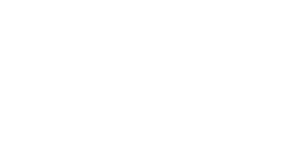

833
833
  VERB1::__init__:: Generating random hash
  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from n_luz = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_illumination:: Updating illumination
  VERB1::set_positions:: Setting positions
  VERB1::set_observer:: Setting observer
      VERB3::set_obse

,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,r_ecl,q_ecl,f_ecl,ns_ecl,x_obs,y_obs,z_obs,r_obs,q_obs,f_obs,ns_obs,x_luz,y_luz,z_luz,r_luz,q_luz,f_luz,ns_luz,n_equ,alpha_equ,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit,hidden
0,65507,0,2,1,"[0, 0, 0]",0.125699,-0.486857,0.0,0.502822,4.965056,0.0,"[0.0, 0.0, 1.0]",0.125699,-0.486857,0.0,0.502822,4.965056,0.0,"[0.0, 0.0, 1.0]",0.125699,-0.486857,0.0,0.502822,4.965056,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",0.125699,-0.486857,0.0,0.502822,4.965056,0.0,"[0, 0, 1]",0,0,0.023562,0.173205,1,0.0,0,1,0,0,0,0,0,0,0
1,65507,0,2,1,"[0, 0, 0]",0.239680,0.450479,0.0,0.510272,1.081834,0.0,"[0.0, 0.0, 1.0]",0.239680,0.450479,0.0,0.510272,1.081834,0.0,"[0.0, 0.0, 1.0]",0.239680,0.450479,0.0,0.510272,1.081834,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",0.239680,0.450479,0.0,0.510272,1.081834,0.0,"[0, 0, 1]",0,0,0.023562,0.173205,1,0.0,0,1,0,0,0,0,0,0,0
2,65507,0,2,1,"[0, 0, 0]",-0.487948,-0.172717,0.0,0.517614,3.481797,0.0,"[0.0, 0.0, 1.0]",-0.487948,-0.172717,0.0,0.517614,3.481797,0.0,"[0.0, 0.0, 1.0]",-0.487948,-0.172717,0.0,0.517614,3.481797,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",-0.487948,-0.172717,0.0,0.517614,3.481797,0.0,"[0, 0, 1]",0,0,0.023562,0.173205,1,0.0,0,1,0,0,0,0,0,0,0
3,65507,0,2,1,"[0, 0, 0]",0.483131,-0.205076,0.0,0.524854,5.881760,0.0,"[0.0, 0.0, 1.0]",0.483131,-0.205076,0.0,0.524854,5.881760,0.0,"[0.0, 0.0, 1.0]",0.483131,-0.205076,0.0,0.524854,5.881760,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",0.483131,-0.205076,0.0,0.524854,5.881760,0.0,"[0, 0, 1]",0,0,0.023562,0.173205,1,0.0,0,1,0,0,0,0,0,0,0
4,65507,0,2,1,"[0, 0, 0]",-0.220681,0.484065,0.0,0.531995,1.998538,0.0,"[0.0, 0.0, 1.0]",-0.220681,0.484065,0.0,0.531995,1.998538,0.0,"[0.0, 0.0, 1.0]",-0.220681,0.484065,0.0,0.531995,1.998538,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",-0.220681,0.484065,0.0,0.531995,1.998538,0.0,"[0, 0, 1]",0,0,0.023562,0.173205,1,0.0,0,1,0,0,0,0,0,0,0


  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [1, 1, 1]
      VERB3::rotation_matrix:: Rotation axis: [-0.70710678  0.70710678  0.        ] [-0.40824829 -0.40824829  0.81649658] [0.57735027 0.57735027 0.57735027]
  VERB1::update_visibility:: Updating visibility


,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,r_ecl,q_ecl,f_ecl,ns_ecl,x_obs,y_obs,z_obs,r_obs,q_obs,f_obs,ns_obs,x_luz,y_luz,z_luz,r_luz,q_luz,f_luz,ns_luz,n_equ,alpha_equ,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit,hidden
0,65507,0,2,1,"[0, 0, 0]",0.125699,-0.486857,0.0,0.502822,4.965056,0.0,"[0.0, 0.0, 1.0]",-0.433143,0.147442,-0.208515,0.502822,2.813495,-0.427601,"[0.0, 0.8164965809277258, 0.5773502691896257]",0.125699,-0.486857,0.0,0.502822,4.965056,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",0.125699,-0.486857,0.0,0.502822,4.965056,0.0,"[0, 0, 1]",0,0,0.023562,0.173205,1,0.0,0,1,0,0,0,0,0,0,0
1,65507,0,2,1,"[0, 0, 0]",0.239680,0.450479,0.0,0.510272,1.081834,0.0,"[0.0, 0.0, 1.0]",0.149057,-0.281756,0.398463,0.510272,5.198989,0.896080,"[0.0, 0.8164965809277258, 0.5773502691896257]",0.239680,0.450479,0.0,0.510272,1.081834,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",0.239680,0.450479,0.0,0.510272,1.081834,0.0,"[0, 0, 1]",0,0,0.023562,0.173205,1,0.0,0,1,0,0,0,0,0,0,0
2,65507,0,2,1,"[0, 0, 0]",-0.487948,-0.172717,0.0,0.517614,3.481797,0.0,"[0.0, 0.0, 1.0]",0.222902,0.269716,-0.381435,0.517614,0.880145,-0.828488,"[0.0, 0.8164965809277258, 0.5773502691896257]",-0.487948,-0.172717,0.0,0.517614,3.481797,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",-0.487948,-0.172717,0.0,0.517614,3.481797,0.0,"[0, 0, 1]",0,0,0.023562,0.173205,1,0.0,0,1,0,0,0,0,0,0,0
3,65507,0,2,1,"[0, 0, 0]",0.483131,-0.205076,0.0,0.524854,5.881760,0.0,"[0.0, 0.0, 1.0]",-0.486636,-0.113515,0.160535,0.524854,3.370760,0.310847,"[0.0, 0.8164965809277258, 0.5773502691896257]",0.483131,-0.205076,0.0,0.524854,5.881760,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",0.483131,-0.205076,0.0,0.524854,5.881760,0.0,"[0, 0, 1]",0,0,0.023562,0.173205,1,0.0,0,1,0,0,0,0,0,0,0
4,65507,0,2,1,"[0, 0, 0]",-0.220681,0.484065,0.0,0.531995,1.998538,0.0,"[0.0, 0.0, 1.0]",0.498330,-0.107526,0.152065,0.531995,6.070671,0.289882,"[0.0, 0.8164965809277258, 0.5773502691896257]",-0.220681,0.484065,0.0,0.531995,1.998538,0.0,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",-0.220681,0.484065,0.0,0.531995,1.998538,0.0,"[0, 0, 1]",0,0,0.023562,0.173205,1,0.0,0,1,0,0,0,0,0,0,0


  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [-0.70710678  0.          0.70710678] [0.70710678 0.         0.70710678]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from n_luz = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_illumination:: Updating illumination
  VERB1::populate_spangler:: Purging 3d sample
  VERB1::purge_sample:: Purging sample


.

    VERB2::populate_spangler:: Sample size 987 is different from spangles 1000. Adjusting.
    VERB2::populate_spangler:: Removing 13 entries to DataFrame
  VERB1::set_positions:: Setting positions
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from n_luz = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_illumination:: Updating illumination
987 987 987



----------------------------------------------------------------------
Ran 1 test in 2.153s

OK


In [14]:
if IN_JUPYTER:
    def test_pop(self):
        Verbose.VERBOSITY=VERB_ALL
        
        #Using preset
        sg=Spangler(nspangles=850)
        sg.populate_spangler(geometry="ring",preset=True,ri=0.5)
        sg.sample.plot()
        print(sg.sample.N)
        print(sg.nspangles)
    
        #Ring
        sg=Spangler(nspangles=100)
        sg.populate_spangler(geometry="ring",scale=1,seed=1,boundary=0)
        print_df(sg.data.head(5))
        sg.set_observer(n_obs=[1,1,1])
        print_df(sg.data.head(5))
        
        #Sphere
        sg=Spangler(nspangles=1000,body_hash="123",n_equ=[1,0,1])
        sg.populate_spangler(geometry="sphere",scale=2,seed=1)
        print(sg.nspangles,sg.sample.N,len(sg.data))
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_pop=test_pop
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [15]:
def plot3d(self,spangled=True,factor=1.2,**args):
    """
    Plot spangle.

    Parameters:
        args: scatter plotting options, dictionary.
    """
    sargs=dict(c='c',s=0.1)
    sargs.update(args)
    bgcolor='k'

    #Figure
    fig=plt.figure(figsize=(5,5))
    fig.patch.set_facecolor(bgcolor)
    ax=fig.add_subplot(111,projection='3d',facecolor=bgcolor)

    ax.axis("off")
    ax.scatter(self.data.x_ecl,self.data.y_ecl,self.data.z_ecl,**sargs)

    #Spangles
    if spangled:
        for i in range(self.nspangles):

            #Define color according to observer
            if self.data.loc[i,"visible"]:
                color='c'
            else:
                color='g'

            #Define color according to illumination
            if self.data.loc[i,"illuminated"]:
                color='y'

            #Define alpha according to albedo
            alpha=0.5*self.data.albedo_gray_normal[i]

            center=[self.data.x_ecl[i],self.data.y_ecl[i],self.data.z_ecl[i]]
            radius=self.data.dsp[i]/2
            zDir=self.data.ns_ecl[i]
            #verbose(VERB_DEEP,i,center,radius,zDir)
            Plot.circle3d(ax,
                          center=center,
                          radius=radius,
                          zDir=zDir,
                          color=color,alpha=alpha)

    ax.set_box_aspect([1,1,1])

    #Range
    maxval=1.0*np.abs(self.data[["x_ecl","y_ecl","z_ecl"]].to_numpy()).max()
    ax.set_xlim(-maxval,maxval)
    ax.set_ylim(-maxval,maxval)
    ax.set_zlim(-maxval,maxval)
    
    #Decoration
    xmin,xmax=factor*np.array(list(ax.get_xlim()))
    ymin,ymax=factor*np.array(list(ax.get_ylim()))
    zmin,zmax=factor*np.array(list(ax.get_zlim()))

    #Axis
    ax.plot([xmin,xmax],[0,0],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[ymin,ymax],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[0,0],[zmin,zmax],'w-',alpha=0.3)
    ax.text(xmax,0,0,r"$x_{ecl}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,ymax,0,r"$y_{ecl}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,0,zmax,r"$z_{ecl}$",color='w',alpha=0.5,fontsize=8)

    #Title
    ax.set_title(f"Spangler {self.geometry}, N = {self.nspangles}",
                 color='w',fontsize=10)
    Plot.pryngles_mark(ax)
    
    #Scale
    ax.text2D(0,0,f"Axis scale: {maxval*factor:.2g}",
            fontsize=8,color='w',
            transform=ax.transAxes)

    #Orientation
    ax.view_init(azim=30)
    fig.tight_layout()

    self.fig3d=fig
    self.ax3d=ax

Spangler.plot3d=plot3d

  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 1, 1]
      VERB3::rotation_matrix:: Rotation axis: [-0.70710678  0.70710678  0.        ] [-0.40824829 -0.40824829  0.81649658] [0.57735027 0.57735027 0.57735027]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from n_luz = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_illumination:: Updating illumination
  VERB1::populate_spangler:: Purging 3d sample
  VERB1::purge_sample:: Purg

<IPython.core.display.Javascript object>


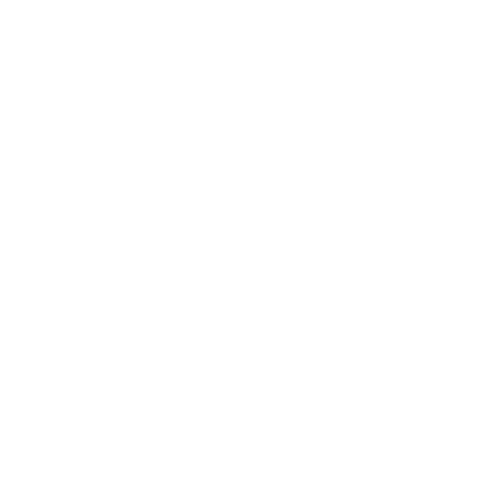

  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 1, 1]
      VERB3::rotation_matrix:: Rotation axis: [-0.70710678  0.70710678  0.        ] [-0.40824829 -0.40824829  0.81649658] [0.57735027 0.57735027 0.57735027]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from n_luz = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_illumination:: Updating illumination
  VERB1::set_positions:: Setting positions
  VERB1::set_observer:: Setting 

<IPython.core.display.Javascript object>


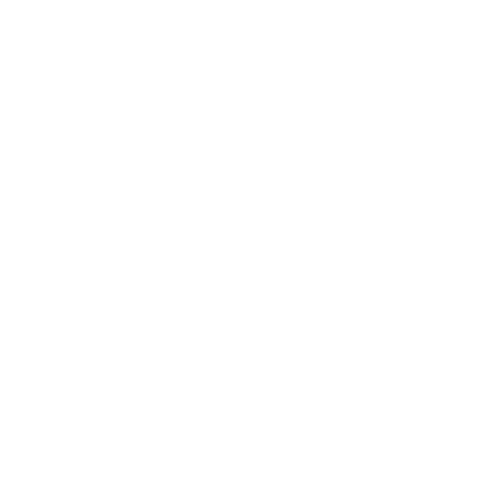

.
----------------------------------------------------------------------
Ran 1 test in 1.050s

OK


In [16]:
if IN_JUPYTER:
    def test_plot3d(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        plt.close("all")
        sg=Spangler(nspangles=500,body_hash="123",n_equ=[1,1,1])
        sg.populate_spangler(geometry="sphere",scale=2,seed=1)
        sg.set_luz(n_luz=[1,0,0])
        sg.plot3d(spangled=False,factor=1.5,c='y',s=3)
        
        sg=Spangler(nspangles=500,body_hash="123",n_equ=[1,1,1])
        sg.populate_spangler(geometry="ring",scale=2,seed=1,boundary=0)
        sg.set_luz(n_luz=[0,0,-1])
        sg.plot3d(factor=0.5)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_plot3d=test_plot3d
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [17]:
def plot_obs(self,spangled=dict(),**args):
    """
    Plot spangle.

    Parameters:
        args: scatter plotting options, dictionary.
    """
    sargs=dict(c='c',sizes=3.5)
    sargs.update(args)
    bgcolor='k'

    #Figure
    fig=plt.figure(figsize=(5,5))
    fig.patch.set_facecolor(bgcolor)
    ax=fig.add_subplot(111,facecolor=bgcolor)
    ax.axis("off")

    #Plot according to state
    
    #Visible
    cond=((self.data.dim==3)&(self.data.visible==1))|((self.data.dim==2))
    sargs.update(dict(c='c',sizes=3.5*self.data.scale[cond]))    
    ax.scatter(self.data.x_obs[cond],self.data.y_obs[cond],**sargs)

    #Illuminated
    cond=((self.data.illuminated==1)&(self.data.visible==1))
    sargs.update(dict(c='y',sizes=3.5*self.data.scale[cond]))    
    ax.scatter(self.data.x_obs[cond],self.data.y_obs[cond],**sargs)

    #Ranges
    maxval=1.2*np.abs(self.data[["x_obs","y_obs","z_obs"]].to_numpy()).max()
    ax.set_xlim(-maxval,maxval)
    ax.set_ylim(-maxval,maxval)
    
    factor=1
    xmin,xmax=factor*np.array(list(ax.get_xlim()))
    ymin,ymax=factor*np.array(list(ax.get_ylim()))

    #Axis
    ax.plot([xmin,xmax],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[ymin,ymax],'w-',alpha=0.3)
    ax.text(xmax,0,r"$x_{obs}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,ymax,r"$y_{obs}$",color='w',alpha=0.5,fontsize=8)

    #Title
    lamb_obs=self.d_obs[1]*Consts.rad
    phi_obs=self.d_obs[2]*Consts.rad
    label_obs=f"Obs ($\lambda$,$\\beta$) : ({lamb_obs:.1f}$^\circ$,{phi_obs:.1f}$^\circ$)"
    ax.set_title(f"Spangler {self.geometry}, N = {self.nspangles}, {label_obs}",
                 color='w',fontsize=10,position=(0.5,+0.5),ha='center')
    Plot.pryngles_mark(ax)

    #Scale
    ax.text(0,0,f"Axis scale: {maxval*factor:.2g}",
              fontsize=8,color='w',
              transform=ax.transAxes)

    #Decoration
    #ax.set_aspect("equal")

    fig.tight_layout()
    self.fig2d=ax
    self.ax2d=ax

Spangler.plot_obs=plot_obs

  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 1, 1]
      VERB3::rotation_matrix:: Rotation axis: [-0.70710678  0.70710678  0.        ] [-0.40824829 -0.40824829  0.81649658] [0.57735027 0.57735027 0.57735027]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [1, 1, 1]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from n_luz = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_illumination:: Updating illumination
  VERB1::populate_spangler:: Populating spangler from preset for sphere
  V

<IPython.core.display.Javascript object>


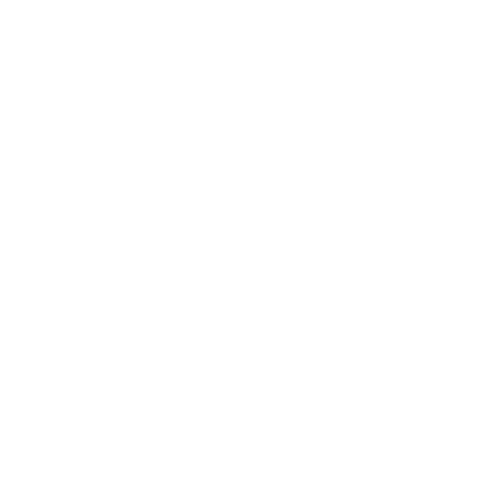

  VERB1::set_positions:: Setting positions
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [1. 0. 0.]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from n_luz = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_illumination:: Updating illumination


<IPython.core.display.Javascript object>


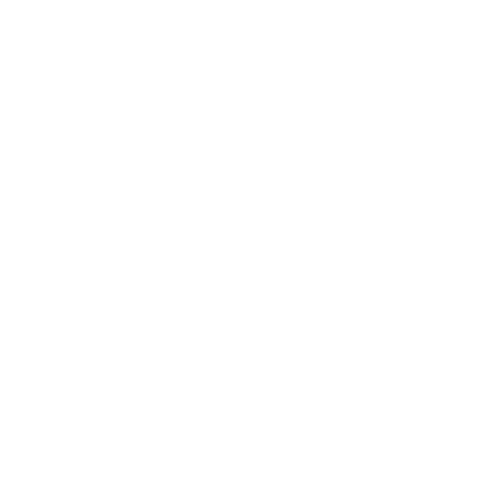

    VERB2::populate_spangler:: Sample size 499 is different from spangles 500. Adjusting.
    VERB2::populate_spangler:: Removing 1 entries to DataFrame
  VERB1::set_positions:: Setting positions
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [1. 0. 0.]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from n_luz = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_illumination:: Updating illumination


<IPython.core.display.Javascript object>


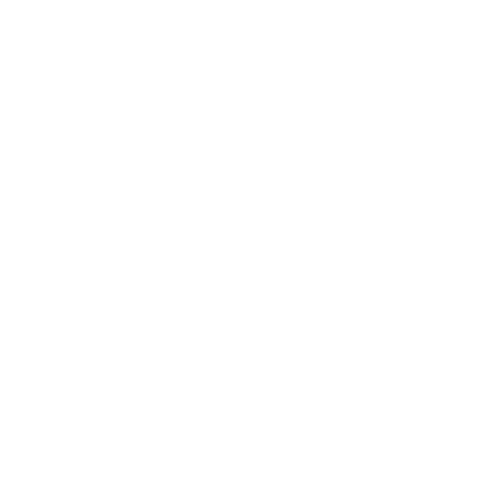

.
----------------------------------------------------------------------
Ran 1 test in 0.938s

OK


In [18]:
if IN_JUPYTER:
    def test_plotobs(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        sg=Spangler(nspangles=500,body_hash="123",n_equ=[1,1,1],center_ecl=[1,1,1])

        sg.populate_spangler(geometry="sphere",scale=2,seed=1,preset=True)
        sg.set_observer(n_obs=[1,0,0])
        sg.plot_obs()

        sg.populate_spangler(geometry="circle",scale=2,seed=1,boundary=0)
        sg.plot_obs()

        sg.populate_spangler(geometry="ring",scale=2,seed=1,ri=0.2,boundary=0)
        sg.plot_obs()
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_plotobs=test_plotobs
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [19]:
def _join_spanglers(self,spanglers,n_obs=[0,0,1],alpha_obs=0,n_luz=[0,0,1]):
    """
    Join spanglers into a single spangler
    
    Parameters:
        spanglers: list of Spanglers:
            Spanglers to join.
            
        n_obs: array(3), default = [0,0,1]:
            Direction of observer.
            
        n_luz: array(3), default = [0,0,1]:
            Direction of light-source.
            
    Return:
        
    """
    #Set of spanglers
    self.spanglers=spanglers
    
    #Concatenate data
    datas=[spangler.data for spangler in spanglers]
    self.data=pd.concat(datas,ignore_index=True)
    
    #Create a list of hashehs
    self.body_hash=[spangler.body_hash for spangler in spanglers]
    
    #Join properties
    self.nspangles=len(self.data)
    self.geometry="Join"
    
    #Set luz and set observer
    self.set_observer(n_obs,alpha_obs)
    self.set_luz(n_luz)
    
Spangler._join_spanglers=_join_spanglers

  VERB1::set_positions:: Setting positions
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [-0.70710678  0.          0.70710678] [0.70710678 0.         0.70710678]
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
  VERB1::set_observer:: Setting observer
      VERB3::set_observer:: Generating observer matrices from n_obs = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
      VERB3::set_luz:: Generating light-source matrices from n_luz = [0. 0. 1.]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
  VERB1::update_illumination:: Updating illumination
  VERB1::set_positions:: Setting positions
  VERB1::set_observer:: Setting observer
      VERB3::set_o

<IPython.core.display.Javascript object>


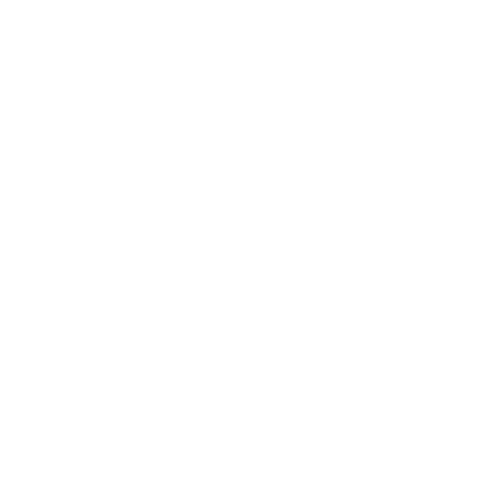

<IPython.core.display.Javascript object>


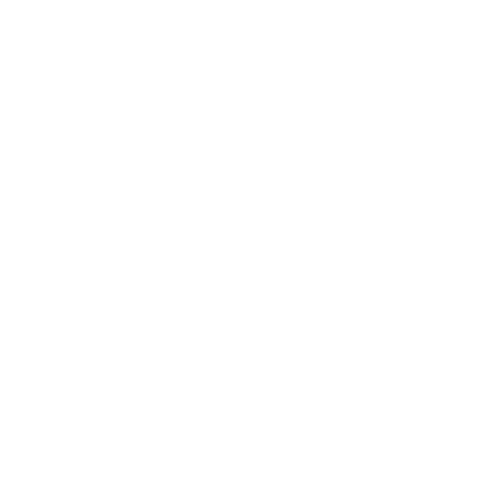

.
----------------------------------------------------------------------
Ran 1 test in 2.039s

OK


In [20]:
if IN_JUPYTER:
    def test_join(self):
        
        Verbose.VERBOSITY=VERB_ALL

        sg1=Spangler(nspangles=1000,body_hash="123",n_equ=[1,0,1])
        sg1.populate_spangler(geometry="ring",scale=2.5,seed=1,ri=1.5/2.5,boundary=0)

        sg2=Spangler(nspangles=1000,body_hash="345",n_equ=[0,0,1])
        sg2.populate_spangler(geometry="sphere",scale=1,seed=1,preset=True)

        sgj=Spangler(spanglers=[sg1,sg2],n_obs=[1,0,0],n_luz=[-1,-1,-1])

        sgj.plot3d()
        sgj.plot_obs()
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_join=test_join
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [21]:
# Set scale
def set_scale(self,scale):
    lengths=[
        "x_equ","y_equ","z_equ",
        "x_ecl","y_ecl","z_ecl",
        "x_obs","y_obs","z_obs",
        "x_luz","y_luz","z_luz",
        "r_equ","r_ecl","r_obs","r_luz",
        "dsp",
    ]
    self.data[lengths]*=scale
    areas=[
        "asp",
    ]
    self.data[areas]*=scale**2
    
Spangler.set_scale=set_scale

In [22]:
if IN_JUPYTER:
    def test_scale(self):

        Verbose.VERBOSITY=VERB_SIMPLE

        sg=Spangler()
        print_df(sg.data)

        sg.set_scale(5)
        print_df(sg.data)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_scale=test_scale
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

  VERB1::__init__:: Generating random hash
  VERB1::set_positions:: Setting positions
  VERB1::set_observer:: Setting observer
  VERB1::update_visibility:: Updating visibility
  VERB1::set_luz:: Setting light-source
  VERB1::update_illumination:: Updating illumination


,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,r_ecl,q_ecl,f_ecl,ns_ecl,x_obs,y_obs,z_obs,r_obs,q_obs,f_obs,ns_obs,x_luz,y_luz,z_luz,r_luz,q_luz,f_luz,ns_luz,n_equ,alpha_equ,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit,hidden
0,51463,0,2,1,"[0, 0, 0]",0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0.0,0.0,1.0,1.0,0.0,1.570796,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",0,0,1,0,0,1.570796,"[0, 0, 1]",0,0,1.0,1.0,1,0.0,0,1,0,0,0,0,0,0,0


,body_hash,type,dim,scale,center_ecl,x_ecl,y_ecl,z_ecl,r_ecl,q_ecl,f_ecl,ns_ecl,x_obs,y_obs,z_obs,r_obs,q_obs,f_obs,ns_obs,x_luz,y_luz,z_luz,r_luz,q_luz,f_luz,ns_luz,n_equ,alpha_equ,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,w,t0,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,visible,shadow,illuminated,transit,indirect,occult,emit,hidden
0,51463,0,2,1,"[0, 0, 0]",0.0,0.0,5.0,5.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0.0,0.0,5.0,5.0,0.0,1.570796,"[0.0, 0.0, 1.0]",0.0,0.0,5.0,5.0,0.0,1.570796,"[0.0, 0.0, 1.0]","[0.0, 0.0, 1.0]",0,"[0, 0, 0]",0,0,5,0,0,1.570796,"[0, 0, 1]",0,0,25.0,5.0,1,0.0,0,1,0,0,0,0,0,0,0


.
----------------------------------------------------------------------
Ran 1 test in 0.092s

OK


--End--